In [1]:
library(dplyr)
library(tidyr)

library(terra)
library(geodata)
library(eurostat)
library(sf)
library(tigris)

library(igraph)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


terra 1.7.78


Attaching package: ‘terra’


The following object is masked from ‘package:tidyr’:

    extract


Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE

To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.


Attaching package: ‘tigris’


The following object is masked from ‘package:terra’:

    blocks



Attaching package: ‘igraph’


The following object is masked from ‘package:tigris’:

    blocks


The following objects are masked from ‘package:terra’:

    blocks, compare, union


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is ma

In [6]:
# Import the table with the levels of the counties
regions <- read.table(file = "../../data/task_44/meta/gadm1_nuts3_counties_levels.csv", sep = ',', header = TRUE)
regions <- regions |> rename(nodeCode = key)

tail(regions)

,nodeCode,level
,<chr>,<chr>
8003,LKA24_318,gadm2
8004,LKA24_319,gadm2
8005,LKA25_320,gadm2
8006,LKA25_321,gadm2
8007,LKA25_322,gadm2
8008,LKA25_323,gadm2


In [7]:
get_nuts3_country <- function(nuts3_code, nuts3_shapefile){
  nuts3_region <- nuts3_shapefile[nuts3_shapefile$id == nuts3_code, ]
  country <- countrycode::countrycode(nuts3_region$CNTR_CODE, origin = "eurostat", destination = "iso3c")
  return(country)
}

In [8]:
# Attach the country to the levels table
regions$country_ISO3 <- sub("^([A-Z]+).*", "\\1", regions$nodeCode)

# Overwrite nuts3 countries with ISO 3 codes
nuts3_shapefile <- eurostat::get_eurostat_geospatial(nuts_level = 3, year = 2016, output_class = "sf")
nuts3_keys <- regions[regions$level == "nuts3", ]$nodeCode
nuts3_countries <- sapply(nuts3_keys, get_nuts3_country, nuts3_shapefile = nuts3_shapefile)
regions[regions$level == "nuts3", ]$country_ISO3 <- nuts3_countries

tail(regions)

Extracting data from eurostat::eurostat_geodata_60_2016



,nodeCode,level,country_ISO3
,<chr>,<chr>,<chr>
8003,LKA24_318,gadm2,LKA
8004,LKA24_319,gadm2,LKA
8005,LKA25_320,gadm2,LKA
8006,LKA25_321,gadm2,LKA
8007,LKA25_322,gadm2,LKA
8008,LKA25_323,gadm2,LKA


In [9]:
regions[regions$level == "gadm1", ]

,nodeCode,level,country_ISO3
,<chr>,<chr>,<chr>
49,DZA1,gadm1,DZA
50,DZA2,gadm1,DZA
51,DZA3,gadm1,DZA
52,DZA4,gadm1,DZA
53,DZA5,gadm1,DZA
54,DZA6,gadm1,DZA
55,DZA7,gadm1,DZA
56,DZA8,gadm1,DZA
57,DZA9,gadm1,DZA


In [10]:
# Get the GADM1 data
gadm1_regions <- regions[regions$level == "gadm1", ]
gadm1_keys <- unique(gadm1_regions$country_ISO3)
gadm1_data <- gadm(gadm1_keys, level = 1, path = "../../data/task_44/", version="3.6")
gadm1_data$nodeCode <- gsub("\\.", "", sub("_1$", "", gadm1_data$GID_1))
gadm1_data <- gadm1_data[match(gadm1_regions$nodeCode, gadm1_data$nodeCode), ]

gadm1_data <- gadm1_data[, (names(gadm1_data) %in% c("nodeCode", "NAME_1"))]

centroids <- terra::centroids(gadm1_data)
coords <- terra::crds(centroids)
gadm1_data$longitude <- coords[, 1]
gadm1_data$latitude <- coords[, 2]

rm(centroids, coords, gadm1_regions, gadm1_keys)

In [11]:
# Merge the data
gadm1_data <- as.data.frame(gadm1_data)
regions <- regions |> 
  left_join(gadm1_data, by = c("nodeCode" = "nodeCode")) |>
  rename(nodeLabel = NAME_1)

rm(gadm1_data)

In [12]:
# Get the GADM2 data
gadm2_regions <- regions[regions$level == "gadm2", ]
gadm2_keys <- unique(gadm2_regions$country_ISO3)
gadm2_data <- gadm(gadm2_keys, level = 2, path = "../../data/task_44/", version="3.6")
gadm2_data$nodeCode <- gsub("(\\w+)\\.(\\d+)\\.(\\d+)_1$", "\\1\\2_\\3", gadm2_data$GID_2)

gadm2_data <- gadm2_data[, (names(gadm2_data) %in% c("nodeCode", "NAME_2"))]

centroids <- terra::centroids(gadm2_data)
coords <- terra::crds(centroids)
gadm2_data$longitude <- coords[, 1]
gadm2_data$latitude <- coords[, 2]

rm(centroids, coords, gadm2_regions, gadm2_keys)

In [13]:
# Convert the data to a data frame
gadm2_data <- as.data.frame(gadm2_data) |> rename(nodeLabel = NAME_2)

# Change the nodeCode to the format of the GADM2 data
gadm2_data <- gadm2_data |>
  separate(nodeCode, into = c("prefix", "n2"), sep = c("_"), remove = TRUE) |>
  separate(prefix, into = c("prefix", "n1"), sep = c("(?<=^[A-Z]{3})"), remove = TRUE) |>
  group_by(prefix) |>
  mutate(sequential_number = row_number()) |>
  ungroup() |>
  mutate(nodeCode = paste0(prefix, n1, "_", sequential_number)) |>
  select(c("nodeCode", "nodeLabel", "longitude", "latitude"))

In [14]:
# Merge the data
regions <- regions |> 
  left_join(gadm2_data, by = c("nodeCode" = "nodeCode"), suffix = c("_x", "_y")) |>
  mutate(nodeLabel = coalesce(nodeLabel_x, nodeLabel_y)) |>
  select(-nodeLabel_x, -nodeLabel_y) |>
  mutate(longitude = coalesce(longitude_x, longitude_y)) |>
  mutate(latitude = coalesce(latitude_x, latitude_y)) |>
  select(-longitude_x, -longitude_y, -latitude_x, -latitude_y)

rm(gadm2_data)

In [15]:
tail(regions)

,nodeCode,level,country_ISO3,nodeLabel,longitude,latitude
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
8003,LKA24_318,gadm2,LKA,Trincomalee Town and Gravets,81.17728,8.580559
8004,LKA24_319,gadm2,LKA,Verugal,81.34639,8.317492
8005,LKA25_320,gadm2,LKA,Vavuniya,80.45494,8.816894
8006,LKA25_321,gadm2,LKA,Vavuniya North,80.59240,9.002291
8007,LKA25_322,gadm2,LKA,Vavuniya South,80.57399,8.769015
8008,LKA25_323,gadm2,LKA,Vengalacheddiculam,80.29340,8.688173


In [16]:
# Get the nuts3 data
nuts3_regions <- regions[regions$level == "nuts3", ]
nuts3_keys <- unique(nuts3_regions$nodeCode)
nuts3_shapefile <- eurostat::get_eurostat_geospatial(nuts_level = 3, year = 2016, output_class = "sf")
nuts3_data <- nuts3_shapefile[match(nuts3_keys, nuts3_shapefile$id), ]

centroids <- st_centroid(nuts3_data$geometry)
coords <- st_coordinates(centroids)
nuts3_data$longitude <- coords[, 1]
nuts3_data$latitude <- coords[, 2]

rm(centroids, coords, nuts3_regions, nuts3_keys)

Extracting data from eurostat::eurostat_geodata_60_2016



In [17]:
# Convert the data to a data frame
nuts3_data <- as.data.frame(nuts3_data) 

nuts3_data <- nuts3_data |>
  rename(nodeLabel = NAME_LATN) |>
  rename(nodeCode = id) |>
  select(c("nodeCode", "nodeLabel", "longitude", "latitude"))

In [18]:
head(nuts3_data)

,nodeCode,nodeLabel,longitude,latitude
,<chr>,<chr>,<dbl>,<dbl>
818,HR043,Krapinsko-zagorska županija,15.920217,46.07827
36,AT314,Steyr-Kirchdorf,14.324103,47.85302
37,AT315,Traunviertel,13.690190,47.82881
322,DE600,Hamburg,9.506859,53.67060
323,DE711,"Darmstadt, Kreisfreie Stadt",8.680591,49.90291
324,DE712,"Frankfurt am Main, Kreisfreie Stadt",8.660673,50.11875


In [19]:
# # Merge the data
regions <- regions |> 
  left_join(nuts3_data, by = c("nodeCode" = "nodeCode"), suffix = c("_x", "_y")) |>
  mutate(nodeLabel = coalesce(nodeLabel_x, nodeLabel_y)) |>
  select(-nodeLabel_x, -nodeLabel_y) |>
  mutate(longitude = coalesce(longitude_x, longitude_y)) |>
  mutate(latitude = coalesce(latitude_x, latitude_y)) |>
  select(-longitude_x, -longitude_y, -latitude_x, -latitude_y)

rm(nuts3_data)

In [22]:
# Get the USA data
usa_regions <- regions[regions$country_ISO3 == "USA", ]
state_fips <- substr(usa_regions$nodeCode, 4, 5)
usa_shapefile <- counties(state = state_fips, year = 2015, cb = TRUE, class = "sf")
usa_shapefile$code <- paste0("USA", usa_shapefile$STATEFP, usa_shapefile$COUNTYFP)
usa_data <- usa_shapefile[match(usa_regions$nodeCode, usa_shapefile$code), ]

centroids <- st_centroid(usa_data$geometry)
coords <- st_coordinates(centroids)
usa_data$longitude <- coords[, 1]
usa_data$latitude <- coords[, 2]


  |======================================================================| 100%


In [23]:
head(usa_data)

ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called ‘geojsonio’

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_geojson.sf(obj)
8. repr_geojson(geo

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,code,longitude,latitude
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>,<chr>,<dbl>,<dbl>
1426,31,039,00835841,0500000US31039,31039,Cuming,06,1477895811,10447360,MULTIPOLYGON (((-97.01989 4...,USA31039,-96.78738,41.91632
2809,53,069,01513275,0500000US53069,53069,Wahkiakum,06,682138871,61658258,MULTIPOLYGON (((-123.7261 4...,USA53069,-123.42400,46.29194
3140,35,011,00933054,0500000US35011,35011,De Baca,06,6015539696,29159492,MULTIPOLYGON (((-104.8915 3...,USA35011,-104.41210,34.34231
1275,31,109,00835876,0500000US31109,31109,Lancaster,06,2169240202,22877180,MULTIPOLYGON (((-96.91393 4...,USA31109,-96.68776,40.78390
2715,31,129,00835886,0500000US31129,31129,Nuckolls,06,1489645187,1718484,MULTIPOLYGON (((-98.27405 4...,USA31129,-98.04719,40.17631
1763,72,085,01804523,0500000US72085,72085,Las Piedras,13,87748363,32509,MULTIPOLYGON (((-65.92834 1...,USA72085,-65.86931,18.18757


In [24]:
usa_data <- as.data.frame(usa_data)

usa_data <- usa_data |>
  rename(nodeLabel = NAME) |>
  rename(nodeCode = code) |>
  select(c("nodeCode", "nodeLabel", "longitude", "latitude"))


In [25]:
# # Merge the data
regions <- regions |> 
  left_join(usa_data, by = c("nodeCode" = "nodeCode"), suffix = c("_x", "_y")) |>
  mutate(nodeLabel = coalesce(nodeLabel_x, nodeLabel_y)) |>
  select(-nodeLabel_x, -nodeLabel_y) |>
  mutate(longitude = coalesce(longitude_x, longitude_y)) |>
  mutate(latitude = coalesce(latitude_x, latitude_y)) |>
  select(-longitude_x, -longitude_y, -latitude_x, -latitude_y)

rm(usa_data)

In [26]:
# Clear regions from NA values
regions <- regions[!is.na(regions$nodeLabel), ]

In [27]:
head(regions)

,nodeCode,level,country_ISO3,nodeLabel,longitude,latitude
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
49,DZA1,gadm1,DZA,Adrar,-0.6198861,26.01378
50,DZA2,gadm1,DZA,Aïn Defla,2.0669765,36.18434
51,DZA3,gadm1,DZA,Aïn Témouchent,-1.0554878,35.35085
52,DZA4,gadm1,DZA,Alger,3.0566231,36.70560
53,DZA5,gadm1,DZA,Annaba,7.5429461,36.83824
54,DZA6,gadm1,DZA,Batna,5.8745511,35.41969


In [28]:
# Add the nodeID
regions <- regions |>
  mutate(nodeID = row_number()) |>
  select(nodeID, everything())

In [29]:
# Save the data
write.csv(regions, "../../data/task_44/networks/full_world_nodes.csv", row.names = FALSE)

## Edges

In [30]:
# Load the data
regions <- read.csv("../../data/task_44/networks/full_world_nodes.csv")

In [31]:
head(regions)

,nodeID,nodeCode,level,country_ISO3,nodeLabel,longitude,latitude
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,1,DZA1,gadm1,DZA,Adrar,-0.6198861,26.01378
2,2,DZA2,gadm1,DZA,Aïn Defla,2.0669765,36.18434
3,3,DZA3,gadm1,DZA,Aïn Témouchent,-1.0554878,35.35085
4,4,DZA4,gadm1,DZA,Alger,3.0566231,36.70560
5,5,DZA5,gadm1,DZA,Annaba,7.5429461,36.83824
6,6,DZA6,gadm1,DZA,Batna,5.8745511,35.41969


In [32]:
# Import the data from meta
path_data_fb <- "../../data/task_44/meta/gadm1_nuts3_counties-gadm1_nuts3_counties - FB Social Connectedness Index - October 2021.tsv"
df <- read.table(file = path_data_fb, sep = "\t", header = TRUE)
print(paste0("Size of df: ", format(object.size(df), units = "auto")))

[1] "Size of df: 1.2 Gb"


In [33]:
# Filter out unknown node codes
df <- df |>
  filter(user_loc %in% regions$nodeCode & fr_loc %in% regions$nodeCode)

In [34]:
# Add the nodeIDs
df <- df |>
  # Add the user nodeID
  left_join (regions |> select(nodeID, nodeCode), by = c("user_loc" = "nodeCode")) |>
  rename(nodeID_from = nodeID) |>
  # Add the friend nodeID
  left_join (regions |> select(nodeID, nodeCode), by = c("fr_loc" = "nodeCode")) |>
  rename(nodeID_to = nodeID) |>
  # Drop the nodeCode columns
  select(nodeID_from, nodeID_to, scaled_sci) |>
  rename(weight = scaled_sci)

In [35]:
# Save the data
write.csv(df, "../../data/task_44/networks/full_world_edges.csv", row.names = FALSE)

## Network

In [2]:
# Read the data
edges <- read.csv("../../data/task_44/networks/full_world_edges.csv")
nodes <- read.csv("../../data/task_44/networks/full_world_nodes.csv")

In [3]:
tail(edges)

,nodeID_from,nodeID_to,weight
,<int>,<int>,<int>
62948351,1836,1831,318504
62948352,1836,1832,305709
62948353,1836,1833,365478
62948354,1836,1834,715880
62948355,1836,1835,722214
62948356,1836,1836,15475362


In [4]:
tail(nodes)

,nodeID,nodeCode,level,country_ISO3,nodeLabel,longitude,latitude
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
7953,7953,LKA24_318,gadm2,LKA,Trincomalee Town and Gravets,81.17728,8.580559
7954,7954,LKA24_319,gadm2,LKA,Verugal,81.34639,8.317492
7955,7955,LKA25_320,gadm2,LKA,Vavuniya,80.45494,8.816894
7956,7956,LKA25_321,gadm2,LKA,Vavuniya North,80.59240,9.002291
7957,7957,LKA25_322,gadm2,LKA,Vavuniya South,80.57399,8.769015
7958,7958,LKA25_323,gadm2,LKA,Vengalacheddiculam,80.29340,8.688173


In [2]:
## Let's start with a simple network
edges <- read.csv("../../data/task_44/networks/ITA_edges.csv")
nodes <- read.csv("../../data/task_44/networks/ITA_nodes.csv")

In [3]:
head(edges)

,nodeID_from,nodeID_to,weight,country_name,country_ISO3
,<int>,<int>,<int>,<chr>,<chr>
1,1,1,655329,Italy,ITA
2,1,2,107245,Italy,ITA
3,1,3,90814,Italy,ITA
4,1,4,27940,Italy,ITA
5,1,5,31055,Italy,ITA
6,1,6,142410,Italy,ITA


In [4]:
tail(nodes)

,nodeCode,nodeID,name,longitude,latitude
,<chr>,<int>,<chr>,<dbl>,<dbl>
105,ITI35,105,Fermo,13.61369,43.08577
106,ITI41,106,Viterbo,11.95749,42.43790
107,ITI42,107,Rieti,12.97034,42.41547
108,ITI43,108,Roma,12.60482,41.91576
109,ITI44,109,Latina,13.28777,41.42200
110,ITI45,110,Frosinone,13.54847,41.64476


In [5]:
# Subselect the data
nodes <- nodes |>
  select(nodeID, longitude, latitude)

edges <- edges |>
  select(nodeID_from, nodeID_to, weight)
  #select(nodeID_from, nodeID_to)

In [6]:
# Create the graph
g <- graph_from_data_frame(edges, directed = FALSE, vertices = nodes)

In [7]:
# Layout the graph according to the geographic coordinates
layout <- matrix(c(nodes$longitude, nodes$latitude), ncol = 2, byrow = FALSE)
rm(nodes, edges)
gc()


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1682954,89.9,2504495,133.8,2504495,133.8
Vcells,2418499,18.5,8388608,64.0,3810037,29.1


In [9]:
# Edge weights
color_ramp <- colorRampPalette(c("grey", "red"))
normalized_weights <- log(log(E(g)$weight + 1) + 1)
edge_colors <- color_ramp(5)[as.numeric(cut(normalized_weights, 5))]

In [10]:
# # Convert the graph to undirected
# g_undirected <- as.undirected(g, mode = "collapse")

# # Use a more efficient layout algorithm
# layout2 <- layout_with_fr(g_undirected)

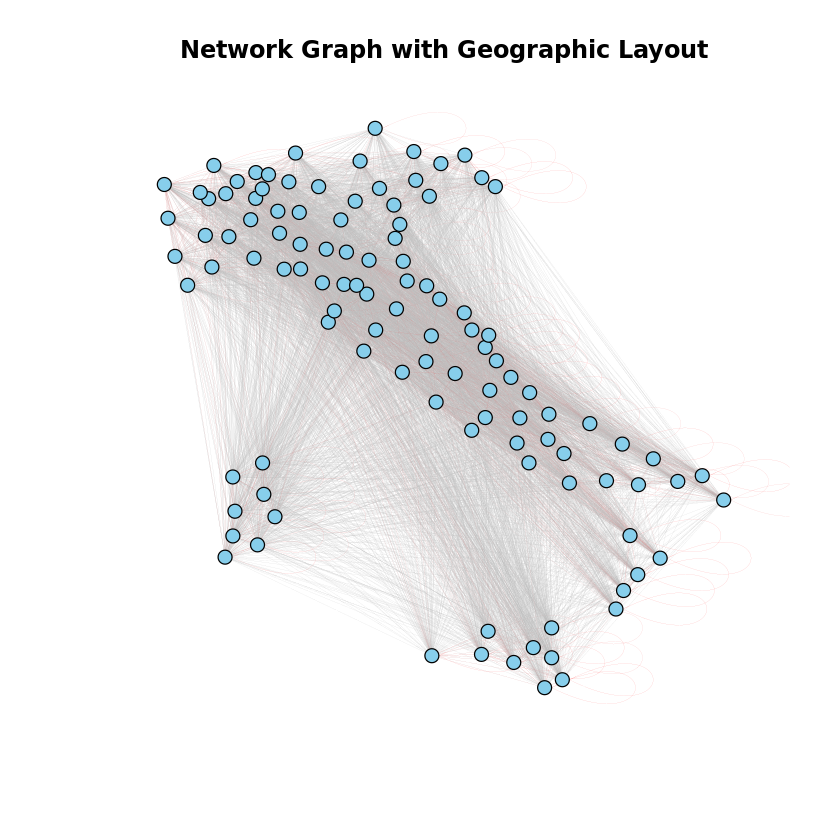

In [15]:
plot(g, layout = layout, vertex.label = NA, edge.width = 0.05,
     vertex.size = 5, vertex.color = "skyblue", edge.color = edge_colors,
     edge.arrow.size = 0, arrow.width = 0,
     main = "Network Graph with Geographic Layout")